# Day 4: Neural Networks Learning

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Used to display images in a specific colormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 7)
import random #To pick random images to display
import scipy.io # Load the OCTAVE *.mat files
import scipy.optimize # fmin_cf to train neural network
import scipy.misc # Show matrix as an image
import random # To pick random images to display
from scipy.special import expit # Vectorized Sigmoid function
import itertools

## 1 Neural Networks

In this exercise, you will implement the backpropagation algorithm to *learn* the parameters for the neural network.

### 1.1 Visualizing the data

In [2]:
data = scipy.io.loadmat('data/ex4data1.mat')
X = np.c_[np.ones((data['X'].shape[0], 1)), data['X']]
y = np.c_[data['y']]
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(5000, 401)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]
(5000, 1)
[[10]
 [10]
 [10]
 [10]
 [10]]


In [3]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)
    plt.xticks([]);plt.yticks([]);

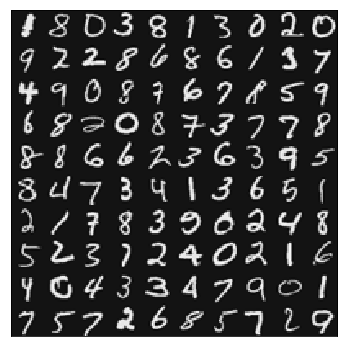

In [4]:
displayData()

### 1.2 Model Representation

In [5]:
weights = scipy.io.loadmat('data/ex4weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']
print(theta1.shape)
print(theta2.shape)

(25, 401)
(10, 26)


Neural Network Model
![nn model](figure/neural-network-model.jpg)

In [6]:
# Some global variables
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10
n_training_samples = X.shape[0]

In [7]:
def flattenParams(thetas_list):
    '''Hand this a list of theta matrices, and it will flatten it
    into one long (n,1) shaped numpy array'''
    flattened_list = [theta.flatten() for theta in thetas_list]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined), 1))

def reshapeParams(flattened_array):
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    return [theta1, theta2]

def flattenX(X):
    return np.array(X.flatten()).reshape((n_training_samples*(input_layer_size+1), 1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples, input_layer_size+1))

### 1.3 Feedforward and cost function

#### Cost Function (without Regularized)
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

In [8]:
def computeCost(thetas_flattened, X_flattened, y, lambd=0.):
    '''Compute cost function of neural networks model
    Parammeters:
        thetas_flattened: flattened vector of theta parameters (each theta would go 
            from one NN layer to the next), the thetas include the bias unit.
        X_flattened: the flattened training set matrix X, which contains the bias 
            unit first column.
        y: the label vector y, which has one column.'''
    
    # First unroll the parameters
    thetas = reshapeParams(thetas_flattened)
    
    # Now unroll X
    X = reshapeX(X_flattened)
    
    #This is what will accumulate the total cost
    total_cost = 0.
    
    m = n_training_samples

    # Loop over the training points (rows in myX, already contain bias unit)
    for irow in range(m):
        row = X[irow]
                
        # First compute the hypothesis (this is a (10,1) vector
        # of the hypothesis for each possible y-value)
        # propagateForward returns (zs, activations) for each layer
        # so propagateforward[-1][1] means "activation for -1st (last) layer"
        hs = propagateForward(row, thetas)[-1][1]

        # Construct a 10x1 "y" vector with all zeros and only one "1" entry
        # note here if the hand-written digit is "0", then that corresponds
        # to a y- vector with 1 in the 10th spot (different from what the
        # homework suggests)
        tmpy  = np.zeros((10,1))
        tmpy[y[irow]-1] = 1
        
        # Compute the cost for this point and y-vector
        cost = -tmpy.T.dot(np.log(hs))-(1-tmpy.T).dot(np.log(1-hs))
     
        # Accumulate the total cost
        total_cost += cost
  
    # Normalize the total_cost, cast as float
    total_cost = float(total_cost) / m
    
    # Compute the regularization term
    total_reg = 0.
    for theta in thetas:
        total_reg += np.sum(theta*theta) #element-wise multiplication
    total_reg *= float(lambd)/(2*m)
        
    return total_cost + total_reg

def propagateForward(row, thetas):
    """
    Function that given a list of Thetas (NOT flattened), propagates the
    row of features forwards, assuming the features ALREADY
    include the bias unit in the input layer, and the 
    Thetas also include the bias unit

    The output is a vector with element [0] for the hidden layer,
    and element [1] for the output layer
        -- Each element is a tuple of (zs, as)
        -- where "zs" and "as" have shape (# of units in that layer, 1)
    
    ***The 'activations' are the same as "h", but this works for many layers
    (hence a vector of thetas, not just one theta)
    Also, "h" is vectorized to do all rows at once...
    this function takes in one row at a time***
    """
   
    features = row
    zs_as_per_layer = []
    for i in range(len(thetas)):  
        theta = thetas[i]
        #Theta is (25,401), features are (401, 1)
        #so "z" comes out to be (25, 1)
        #this is one "z" value for each unit in the hidden layer
        #not counting the bias unit
        z = theta.dot(features).reshape((theta.shape[0],1))
        a = expit(z)
        zs_as_per_layer.append( (z, a) )
        if i == len(thetas)-1:
            return np.array(zs_as_per_layer)
        a = np.insert(a,0,1) #Add the bias unit
        features = a

In [9]:
# Once you are done, using the loaded set of parameters Theta1 and Theta2,
# you should see that the cost is about 0.287629
thetas = [theta1, theta2]

print(computeCost(flattenParams(thetas), flattenX(X), y))

0.287629165161


### 1.4 Regularized cost function

#### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

In [10]:
# Once you are done, using the loaded set of parameters Theta1 and Theta2,
# and lambda = 1, you should see that the cost is about 0.383770
thetas = [theta1, theta2]
print(computeCost(flattenParams(thetas), flattenX(X), y, lambd=1.))

0.384487796243


## 2  Backpropagation

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. 

After you have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.

### 2.1 Sigmoid gradient

#### $$ g'(z) = g(z)(1 - g(z))$$
where $$ g(z) = \frac{1}{1+e^{-z}}$$

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

### 2.2 Random initialization

In [12]:
def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [np.random.rand(*theta1_shape) * 2 * epsilon_init - epsilon_init, \
                   np.random.rand(*theta2_shape) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

### 2.3 Backpropagation

Now, you will implement the backpropagation algorithm.
![backpropagation](figure/backpropagation_updates.jpg)

In [13]:
def backPropagate(thetas_flattened, X_flattened, y, lambd=0.):
    '''Implement the backpropagation algorithm. Obtain the (unregularized) gradient
    for the neural network cost function.
    Parameters:
        thetas_flattened: flattened vector of theta parameters (each theta would go 
            from one NN layer to the next), the thetas include the bias unit.
        X_flattened: the flattened training set matrix X, which contains the bias 
            unit first column.
        y: the label vector y, which has one column.'''
    
    # First unroll the parameters
    thetas = reshapeParams(thetas_flattened)
    
    # Now unroll X
    X = reshapeX(X_flattened)

    #Note: the Delta matrices should include the bias unit
    #The Delta matrices have the same shape as the theta matrices
    Delta1 = np.zeros((hidden_layer_size, input_layer_size+1))
    Delta2 = np.zeros((output_layer_size, hidden_layer_size+1))

    # Loop over the training points (rows in myX, already contain bias unit)
    m = n_training_samples
    for irow in range(m):
        row = X[irow]
        a1 = row.reshape((input_layer_size+1, 1))
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        temp = propagateForward(row, thetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((10,1))
        tmpy[y[irow]-1] = 1
        delta3 = a3 - tmpy 
        delta2 = thetas[1].T[1:,:].dot(delta3)*sigmoidGradient(z2) #remove 0th element
        a2 = np.insert(a2, 0, 1, axis=0)
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #Regularization:
    D1[:,1:] += (float(lambd)/m)*thetas[0][:,1:]
    D2[:,1:] += (float(lambd)/m)*thetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()

In [14]:
flattened_D1_D2 = backPropagate(flattenParams(thetas), flattenX(X), y, lambd=0.)
D1, D2 = reshapeParams(flattened_D1_D2)

### 2.4 Gradient Checking

In [15]:
def checkGradient(thetas, Ds, X, y, lambd=0.):
    eps = 0.0001
    flattened = flattenParams(thetas)
    flattenedDs = flattenParams(Ds)
    X_flattened = flattenX(X)
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = eps
        cost_high = computeCost(flattened + epsvec, X_flattened, y, lambd)
        cost_low  = computeCost(flattened - epsvec, X_flattened, y, lambd)
        grad = (cost_high - cost_low) / float(2*eps)
        print("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x, grad,flattenedDs[x]))

In [16]:
checkGradient(thetas, [D1, D2], X, y)

Element: 6842. Numerical Gradient = -0.000002. BackProp Gradient = -0.000002.
Element: 10055. Numerical Gradient = 0.000509. BackProp Gradient = 0.000509.
Element: 6513. Numerical Gradient = -0.000098. BackProp Gradient = -0.000098.
Element: 9861. Numerical Gradient = -0.000158. BackProp Gradient = -0.000158.
Element: 7905. Numerical Gradient = 0.000042. BackProp Gradient = 0.000042.
Element: 3740. Numerical Gradient = -0.000060. BackProp Gradient = -0.000060.
Element: 3570. Numerical Gradient = -0.000000. BackProp Gradient = -0.000000.
Element: 7737. Numerical Gradient = -0.000024. BackProp Gradient = -0.000024.
Element: 2523. Numerical Gradient = 0.000161. BackProp Gradient = 0.000161.
Element: 928. Numerical Gradient = -0.000101. BackProp Gradient = -0.000101.


### 2.5 Regularized Neural Networks

After you have successfully implemeted the backpropagation algorithm, you will add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term after computing the gradients using backpropagation. Because my back propagation already has regularization in it, I will assume the regularization part is correct.

### 2.6 Learning parameters using *fmincg*

In [17]:
def trainNN(lambd=0.):
    """
    Function that generates random initial theta matrices, optimizes them,
    and returns a list of two re-shaped theta matrices
    """

    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X), y, lambd), maxiter=50, disp=True, full_output=True)
    return reshapeParams(result[0])

In [18]:
# Training the NN takes about ~70-80 seconds on my machine
learned_Thetas = trainNN()

         Current function value: 0.240315
         Iterations: 50
         Function evaluations: 120
         Gradient evaluations: 120


### 3 Visualizing the hidden layer

In [19]:
def displayHiddenLayer(theta):
    """
    Function that takes slices of the first Theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into a 20x20 image, and shows it
    """
    #remove bias unit:
    theta = theta[:,1:]
    assert theta.shape == (25,400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height*nrows, width*ncols))
    
    irow, icol = 0, 0
    for row in theta:
        if icol == ncols:
            irow += 1
            icol  = 0
        #add bias unit back in?
        iimg = getDatumImg(np.insert(row,0,1))
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

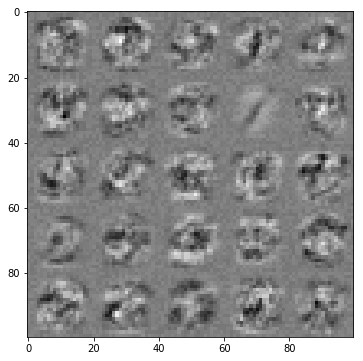

In [20]:
displayHiddenLayer(learned_Thetas[0])